# DATA 601 - Working with Data and Visualization
# **Team Project - A Data-Driven Exploration of the Substance Abuse Crisis**
# Submitted by:
* Joao Ricardo Bertti Targino - 30271085
* Ruby Nouri Kermani -  30261323


## **Introduction**

The opioid and stimulant crisis has emerged as one of the most pressing public health challenges in Canada, with devastating consequences for individuals, families, and communities. According to data from the Canadian Institute for Health Information (CIHI) and other sources, the rates of opioid- and stimulant-related deaths and hospitalizations have risen sharply in recent years, highlighting the urgent need for targeted interventions and policy responses. This crisis is fueled by a complex interplay of factors, including the availability of potent synthetic opioids like fentanyl, the increasing use of stimulants such as methamphetamine, and broader social determinants of health like poverty, mental illness, and lack of access to treatment. By analyzing trends in death rates and hospitalizations, this project aims to shed light on the scope of the crisis and identify patterns that can inform prevention and harm reduction strategies.



## **Guiding Questions**

The opioid and stimulant crisis in Canada has reached alarming levels, with rising death rates and hospitalizations underscoring the urgent need for a deeper understanding of its causes and impacts. This project seeks to explore key dimensions of this crisis by addressing four guiding questions:


1.   What is the growth percentage of incidents by province from 2016 to 2023?
2.   Is there a specific demographic group (age, sex) in which the growth was more prevalent?
3. Is weather relevant to the number of incidents?
4. What is the share of intentional deaths and hospitalizations overall, and is it increasing or decreasing?

Throughout our process, we also explored additional questions:

5. Regarding Question 4, what is the difference if we deep-dive by Age Groups and Gender?
6. Can we draw a correlation between homicides/crime rate and substance abuse?

These questions are designed to uncover patterns and trends that can inform targeted public health interventions and policies. By analyzing provincial data, we aim to identify regions that have been disproportionately affected and understand how the crisis has evolved over time. Additionally, examining demographic trends will help us determine whether certain groups, such as specific age cohorts or genders, are more vulnerable, enabling the development of tailored support programs.

The inclusion of weather as a potential factor reflects the growing recognition that environmental conditions may influence substance use patterns and related harms. For example, extreme weather events or seasonal changes could impact access to resources, mental health, or the availability of illicit substances. Finally, exploring the share of intentional deaths and hospitalizations provides critical insights into the intersection of substance use and mental health, as well as the potential role of self-harm or suicide in the crisis. Answering these questions will not only deepen our understanding of the opioid and stimulant epidemic but also provide actionable insights for policymakers, healthcare providers, and community organizations working to reduce harm and save lives. Through this analysis, we hope to contribute to a more nuanced and data-driven approach to addressing one of Canada’s most pressing public health challenges.


## **Packages**

The team has made use of Python packages for the purpose of this project. These packages assist in importing modules that will aid in the analysis of the chosen dataset. Below is a detailed explanation of how we have utilized each package that is imported in the code-block below this cell.

**Pandas**

The Pandas Python library has been imported in order to easily manipulate numerical tables and time series data. It helped the team to read the dataset into the Jupyter Notebook.

**NumPy**

This Python library has been imported in order to work with arrays, matrices in a quick and efficient manner. Specifically, we use NumPy to calculate various statistics from the datatset to analyze the data that goes along with the data visualizations

**Seaborn**

The Seaborn Python data visualization library has been imported to provide high-level and informative statistical graphics to capture the data story-telling aspect of the project. This library is used for our numeric variables to create visualizations such as: scatter plots, box plots, histograms, and correlation matrices. For categorical variables, visualizations include: bar charts. Seaborn has allowed the team to create more elegant and complex plots in certain situations.

**Matplotlib**

This Python library has been imported in order to create easy-to-read visualizations, including various plots, add customizations to styles and layouts of the visualizations, and embed into the Jupyter Notebook. This library is used for our numeric variables to create visualizations such as: scatter plots, box/violin plots, histograms, and correlation matrices. For categorical variables, visualizations include: bar charts.

**Regex**

This tool has been imported to utilize and extract relevant data from the text fields in the dataset. Regular expressions are powerful tools for searching, matching, and extracting specific patterns within strings.

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

## **Dataset**

The dataset used for this project is sourced from the Health Infobase platform, a comprehensive repository managed by the Public Health Agency of Canada. It provides detailed and up-to-date information on substance-related harms, including opioid- and stimulant-related deaths and hospitalizations across Canada. The dataset spans from 2016 to 2023, offering a longitudinal view of the crisis, and includes variables such as geographic location (province/territory), demographic information (age, sex), and contextual factors like intentionality (e.g., accidental vs. intentional incidents). This rich dataset allows for a granular analysis of trends, enabling us to explore provincial variations, demographic disparities, and potential environmental influences such as weather. By leveraging this data, we can identify high-risk populations, track the effectiveness of public health interventions, and uncover hidden patterns that may inform future strategies to mitigate the impact of the opioid and stimulant crisis. The dataset’s reliability and comprehensiveness make it an invaluable resource for understanding the scope and scale of this public health emergency.

## Detailed Summary about the Dataset

### Table 1: Opioid and Stimulant-Related Deaths and Hospitalizations

* Columns: 12
* Rows: 28,000
* Data Reported from the Years: 2016 - 2023
* Number of Provinces/Territories Reported on: 13 (All Canadian provinces and territories)
* **Additional Notes**: Notable columns include province/territory, year, demographic information (age, sex), type of substance (opioids, stimulants), intentionality (accidental vs. intentional incidents), and environmental factors (e.g., weather conditions). The dataset provides detailed insights into trends in death rates, hospitalizations, and the impact of public health interventions over time.
* **Calculation methods**:
  *  _Crude Rate_: Expressed per 100,000 people, commonly used for provincial-level data.
  *  _Percent_: Represents the proportion within a specific group and event.
  * _Number_: The total count of cases within a given group and event.


### Table 2: Incident-based crime statistics, by detailed violations, police services in the Atlantic provinces

* Columns: 15
* Rows: approximate 280
* Data Reported from the Years: 2019 - 2023
* Number of Provinces/Territories Reported on: 8 (Canada as a whole, Atlantic Region, Quebec, Ontario, Manitoba, Saskatchewan, Alberta, British Columbia, and the Territories)
* **Additional Notes**: Notable columns include key metrics such as the total number of homicide victims, the percentage of homicides linked to organized crime, and the rate of such homicides per 100,000 population.

In [151]:
df = pd.read_csv('Dataset.csv')

In [152]:
crime_dataset = pd.read_csv('crime_dataset.csv')

## **Data Cleaning and Wrangling**

Before starting the analysis, we will make some adjustments to the first dataset to improve readability, visualization and to make it easier to understand.

**1.** We will group smaller provinces within their geography. New Brunswick, Nova Scotia, Prince Edward Island and Newfoundland and Labrador will be grouped as _Atlantic Canada_ and Northwest Territories, Nunavut and Yukon will be grouped as _Canadian Territories_.

**2.** The column PRUID will be dropped as contains only an ID related to the column 'Type Event'

**3.** Some Data were supressed by the Provincial/Federal Governments and appear as "Suppr." on the column 'Value'. We will drop these rows as they have no valuable data.

**4.** We will split the datasets into Opioids and Stimulants, as each group of substance will be compared separately.

In [153]:
df['Region'].unique()

array(['Canada', 'British Columbia', 'Alberta', 'Saskatchewan',
       'Manitoba', 'Ontario', 'Quebec', 'New Brunswick', 'Nova Scotia',
       'Prince Edward Island', 'Newfoundland and Labrador', 'Yukon',
       'Northwest Territories', 'Nunavut', 'at', 'Territories',
       'Winnipeg, Manitoba', 'Northern and rural Manitoba',
       'Whitehorse, Yukon', 'Yellowknife, Northwest Territories'],
      dtype=object)

In [154]:
#Dropping PRUID
df = df.drop(['PRUID'],axis=1)

In [155]:
#Grouping Provinces by their Geography
df['Region'] = df['Region'].replace(['New Brunswick', 'Nova Scotia','Prince Edward Island', 'Newfoundland and Labrador'], 'Atlantic Canada')
df['Region'] = df['Region'].replace(['Yukon','Northwest Territories', 'Nunavut', 'Territories'], 'Canadian Territories')

In [156]:
#Dropping rows with Suppressed values
df = df.loc[df['Value'] != 'Suppr.']

In [157]:
#Adjusting the Data Type for 'Value' column
df['Value'] = df['Value'].astype('float')

Some adjustments we did on the second dataset:

1. Renaming _'Atlantic Canada'_ and _'Canadian Territories'_ to match with our first dataset.
2. We decided to do the analysis only on the data related to Organized Crime Homocides.
3. Doing the analysis only on the data based on Total Deaths related to Substances.
4. Converting _'Year'_ column into integers for better access.


In [158]:
crime_dataset['Homicides'].unique()

array(['Total number of homicide victims',
       'Number of homicide victims for which the status of the link between the homicide and organized crime or a street gang was reported as unknown',
       'Number of homicide victims for which the status of the link between the homicide and organized crime or a street gang was known',
       'Number of homicide victims where the homicide was linked or suspected to be linked to organized crime or a street gang',
       'Victims of homicides linked to organized crime or a street gang as a percentage of homicides for which the link between the homicide and organized crime or a street gang was known',
       'Rate of homicides (number of victims per 100,000 population) where the homicide was linked or suspected to be linked to organized crime or a street gang'],
      dtype=object)

In [159]:
crime_dataset = crime_dataset[['REF_DATE','GEO','Homicides','VALUE']]

#Renaming 'Atlatic Region' to 'Atlantic Canada' and 'Territories' to 'Canadian Territories' as we did with our Substance dataset
crime_dataset['GEO'] = crime_dataset['GEO'].replace({'Atlantic Region':'Atlantic Canada','Territories':'Canadian Territories'})

In [160]:
#Filtering only Organized Crime Homicides
crime_1 = crime_dataset.loc[crime_dataset['Homicides'] == 'Number of homicide victims for which the status of the link between the homicide and organized crime or a street gang was known']

#Renaming to avoid confusion before merging
crime_1 = crime_1.rename({'Homicides':'Category','VALUE':'Homicides'},axis=1)
crime_1 = crime_1[['REF_DATE','GEO','Homicides']]

In [161]:
#Filtering only Total Deaths related to Substances to Start the analysis
eq_df = df.loc[(df['Source'] == 'Deaths') & (df['Time_Period'] == 'By year') & (df['Specific_Measure'] == 'Overall numbers') & (df['Year_Quarter'] != '2024 (Jan to Jun)')]
eq_df = eq_df.loc[(eq_df['Type_Event'] == 'Total apparent opioid toxicity deaths') | (eq_df['Type_Event'] == 'Total apparent stimulant toxicity deaths')]

#Cleaning the Dataset to make it easier for manipulation
eq_df = eq_df[['Substance','Type_Event','Region','Year_Quarter','Unit','Value']]
eq_df = eq_df.rename({'Value':'Total Deaths'},axis=1)
#Converting Year to int
eq_df['Year_Quarter']=eq_df['Year_Quarter'].astype(int)

## **Exploratory Data Analysis (EDA)**

### Guiding Question 1: What is the growth percentage of incidents by Province from 2016 to 2023?

In [162]:
gq1_o = df.loc[(df['Type_Event'] == 'Total apparent opioid toxicity deaths') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Opioids')]
gq1_s = df.loc[(df['Type_Event'] == 'Total apparent stimulant toxicity deaths') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Stimulants')]

In [163]:
gq1_o = pd.pivot_table(data=gq1_o,index='Region',columns='Year_Quarter',values='Value',aggfunc='sum').reset_index()
gq1_s = pd.pivot_table(data=gq1_s,index='Region',columns='Year_Quarter',values='Value',aggfunc='sum').reset_index()

To perform a better analysis and answer this question, lets calculate the **Compound Annual Growth Rate (CAGR)**. This tool is useful when we want to perform a study with a determined variable over time, specially when the value of the time-series data is independent in time.

The CAGR is determined by:

$$
CAGR = \left( \frac{V_f}{V_i} \right)^{\frac{1}{n}}-1
$$

Where:
- $( V_{f} )$ = Final Value (e.g., value in 2023)
- $( V_{i} )$ = Initial Value (e.g., value in 2016)
- $( n )$ = Number of years


In [164]:
#Calculating the Compound Annual Growth Rate
gq1_o['CAGR'] = ((gq1_o['2023']/gq1_o['2016'])**(1/8))-1
gq1_s['CAGR'] = ((gq1_s['2021']/gq1_s['2018'])**(1/4))-1

In [165]:
#Adjusting the Calculation of the CAGR due to inconsistencies on the data
gq1_s.loc[gq1_s['Region'] == 'Quebec', 'CAGR'] = ((gq1_s['2021']/gq1_s['2018'])**(1/4))-1
gq1_s.loc[gq1_s['Region'] == 'Manitoba', 'CAGR'] = ((gq1_s['2023']/gq1_s['2019'])**(1/5))-1
gq1_s.loc[gq1_s['Region'] == 'Canadian Territories', 'CAGR'] = ((gq1_s['2023']/gq1_s['2020'])**(1/4))-1

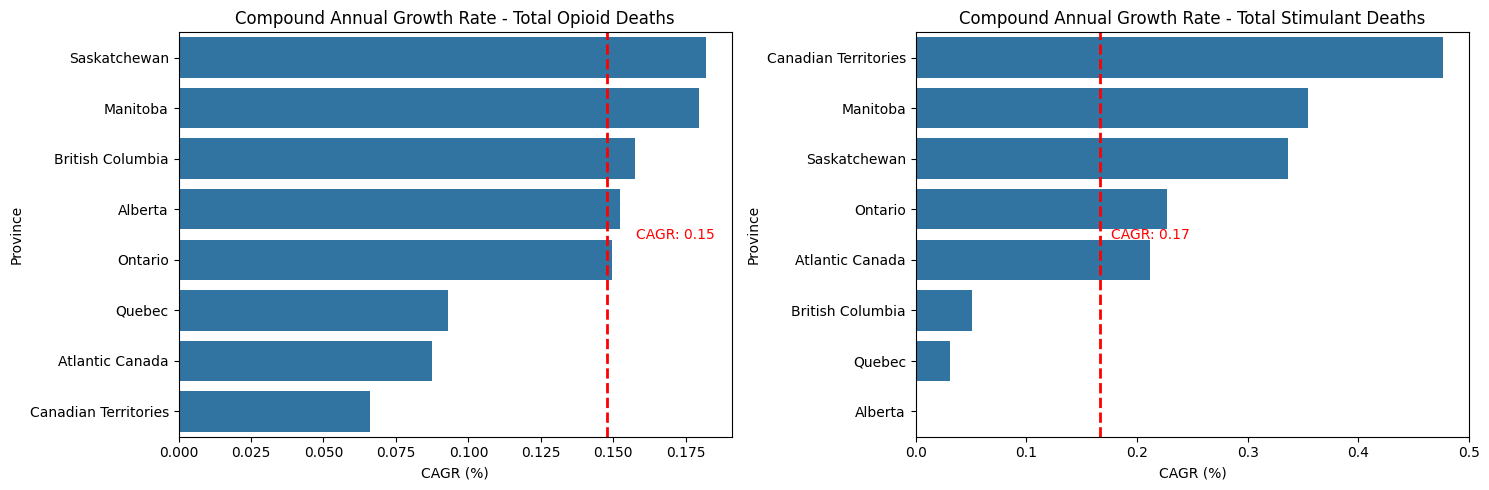

In [166]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(data=gq1_o.loc[gq1_o['Region'] != 'Canada'].sort_values(by='CAGR',ascending=False),x='CAGR',y='Region',ax=axes[0])
axes[0].set_title('Compound Annual Growth Rate - Total Opioid Deaths')
axes[0].set_xlabel('CAGR (%)')
axes[0].set_ylabel('Province')
canada_cagr = gq1_o.loc[gq1_o['Region'] == 'Canada', 'CAGR'].values[0]
axes[0].axvline(x=canada_cagr, color="red", linewidth=2, linestyle='--')
axes[0].text(canada_cagr + 0.01, 0.5, f'CAGR: {canada_cagr:.2f}', rotation=0, color='red', fontsize=10, ha='left', va='center', transform=axes[0].get_xaxis_transform())


sns.barplot(data=gq1_s.loc[gq1_s['Region'] != 'Canada'].sort_values(by='CAGR',ascending=False),x='CAGR',y='Region',ax=axes[1])
axes[1].set_title('Compound Annual Growth Rate - Total Stimulant Deaths')
axes[1].set_xlabel('CAGR (%)')
axes[1].set_ylabel('Province')
canada_cagr_s = gq1_s.loc[gq1_o['Region'] == 'Canada', 'CAGR'].values[0]
axes[1].axvline(x=canada_cagr_s, color="red", linewidth=2, linestyle='--')
axes[1].text(canada_cagr_s + 0.01, 0.5, f'CAGR: {canada_cagr_s:.2f}', rotation=0, color='red', fontsize=10, ha='left', va='center', transform=axes[1].get_xaxis_transform())


plt.tight_layout()

The charts above display the **Compound Annual Growth Rate (CAGR)** for opioid and stimulant deaths across Canadian provinces from 2016 to 2023. The **<span style="color: navy;">blue bars</span>** represent the growth rate for each province, and the **<span style="color: red;">red line</span>** shows the national rate for Canada.

##### **Opioids**:
The highest growth in opioid deaths occurred in Manitoba and Saskatchewan, with a CAGR of about **17.5%**.

Three provinces with a large population share — Alberta (AB), British Columbia (BC), and Ontario (ON) — had growth rates of around 15%. Quebec, despite being the third most populous, saw growth similar to smaller regions like Atlantic Canada and the Territories - approximately 10%. Nationally, Canada’s CAGR for opioid deaths from 2016 to 2023 was **14.8%**.

##### **Stimulants:**
Stimulant data posed challenges as Alberta didn’t report, Quebec stopped in 2021, and Manitoba only began reporting in 2019. Therefore, CAGR calculations were adjusted for these reporting gaps.

Similar to opioids, stimulant-related deaths were notably higher in Central Canada, where growth rates exceeded **30%**. Nationally, Canada’s stimulant death growth was about half that rate. British Columbia and Quebec were exceptions, with growth rates under 5%. Canadian Territories figures while concerning, have to be taken with caution because the size of the sample and population, but a **45%** Growth increase is always concerning.

This highlights regional differences in stimulant-related deaths, with Central Canada seeing the largest increases, while British Columbia and Quebec experienced more less aggressive trends.

### Guiding Question 2: Is there a specific group (Age, Sex) in which the growth was more prevalent?

##### Overall - Age Group and Gender

In [167]:
gq2_o_overall = df.loc[(df['Type_Event'] == 'Total apparent opioid toxicity deaths') & (df['Unit'] == 'Percent') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Opioids') & (df['Year_Quarter'] != '2024 (Jan to Jun)')]
gq2_s_overall = df.loc[(df['Type_Event'] == 'Total apparent stimulant toxicity deaths') & (df['Unit'] == 'Percent') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Stimulants')& (df['Year_Quarter'] != '2024 (Jan to Jun)')]

In [168]:
age_groups = ['0 to 19 years', '20 to 29 years','30 to 39 years', '40 to 49 years', '50 to 59 years','60 years or more']
gq2_o_age = gq2_o_overall.loc[gq2_o_overall['Disaggregator'].isin(age_groups)]
gq2_s_age = gq2_s_overall.loc[gq2_s_overall['Disaggregator'].isin(age_groups)]

In [169]:
genders = ['Male','Female']
gq2_o_gender = gq2_o_overall.loc[gq2_o_overall['Disaggregator'].isin(genders)]
gq2_s_gender = gq2_s_overall.loc[gq2_s_overall['Disaggregator'].isin(genders)]

In [170]:
gq2_o_age = pd.pivot(data=gq2_o_age,index='Disaggregator',columns='Year_Quarter',values='Value').reset_index()
gq2_s_age = pd.pivot(data=gq2_s_age,index='Disaggregator',columns='Year_Quarter',values='Value').reset_index()
gq2_o_age = gq2_o_age.set_index('Disaggregator')
gq2_s_age = gq2_s_age.set_index('Disaggregator')

gq2_o_gender = pd.pivot(data=gq2_o_gender,index='Disaggregator',columns='Year_Quarter',values='Value').reset_index()
gq2_s_gender = pd.pivot(data=gq2_s_gender,index='Disaggregator',columns='Year_Quarter',values='Value').reset_index()
gq2_o_gender = gq2_o_gender.set_index('Disaggregator')
gq2_s_gender = gq2_s_gender.set_index('Disaggregator')

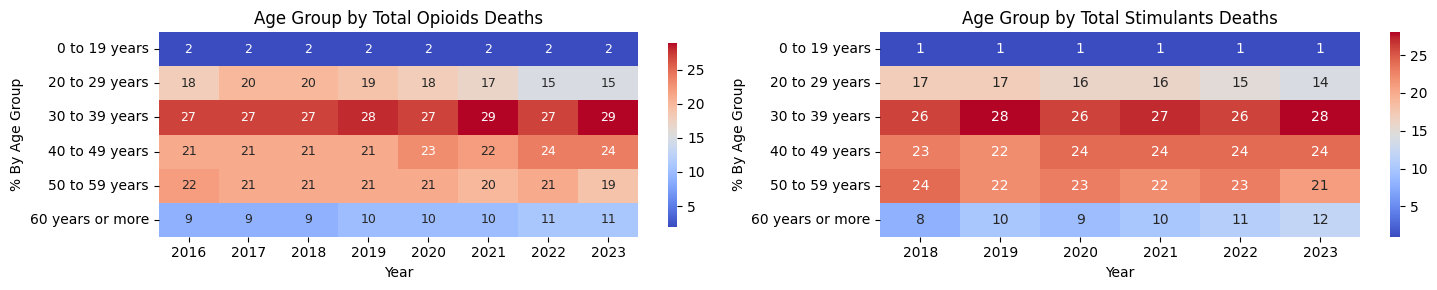

In [171]:
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 3))

sns.heatmap(data=gq2_o_age,cmap='coolwarm',ax=axes2[0],annot=True,annot_kws={"size": 9}, cbar_kws={'shrink': 0.9})
axes2[0].set_title('Age Group by Total Opioids Deaths')
axes2[0].set_ylabel('% By Age Group')
axes2[0].set_xlabel('Year')

sns.heatmap(data=gq2_s_age,cmap='coolwarm',ax=axes2[1],annot=True)
axes2[1].set_title('Age Group by Total Stimulants Deaths')
axes2[1].set_ylabel('% By Age Group')
axes2[1].set_xlabel('Year')

plt.tight_layout()

#### **Age Group**

The data indicates that individuals aged **30 to 39 years** are the most affected, followed closely by those aged **40 to 49 years**. Notably, the presence of **young adults (0–19 years)** in these statistics is concerning, with **2% of opioid-related cases and 1% of stimulant-related cases**. Additionally, there is a growing impact on the **60+ age group**, with opioid-related cases rising from **9% in 2016 to 11% in 2023**. The trend is even more pronounced for stimulants, where cases in this age group increased by **50% (from 8% to 12%)**. Given the overall rise in substance-related deaths, the **increasing impact on both older adults and younger individuals** is a significant public health concern.


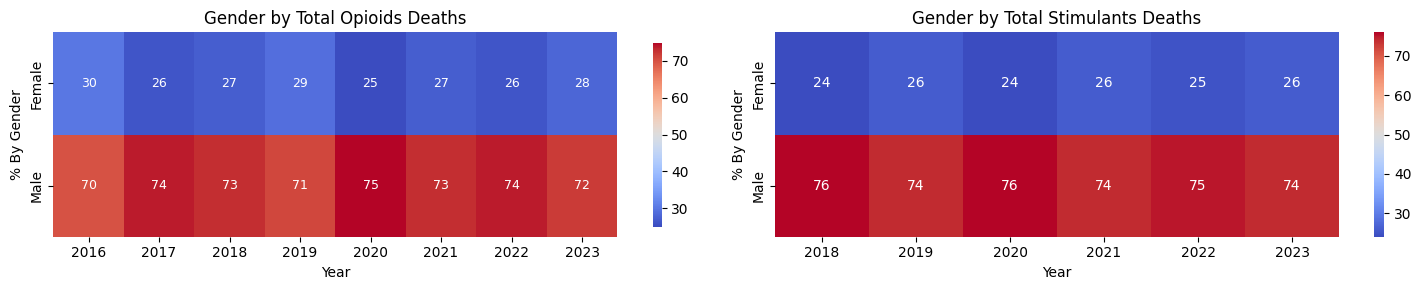

In [172]:
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 3))

sns.heatmap(data=gq2_o_gender,cmap='coolwarm',ax=axes2[0],annot=True,annot_kws={"size": 9}, cbar_kws={'shrink': 0.9})
axes2[0].set_title('Gender by Total Opioids Deaths')
axes2[0].set_ylabel('% By Gender')
axes2[0].set_xlabel('Year')

sns.heatmap(data=gq2_s_gender,cmap='coolwarm',ax=axes2[1],annot=True)
axes2[1].set_title('Gender by Total Stimulants Deaths')
axes2[1].set_ylabel('% By Gender')
axes2[1].set_xlabel('Year')

plt.tight_layout()

#### **Gender**

There is a clear **male predominance** in substance-related deaths, with males **consistently representing over 70%** of cases. While opioid-related fatalities among females declined slightly from **30% in 2016 to 28% in 2023**, the opposite trend is observed for stimulants, where the proportion of female cases increased **from 24% in 2018 to 26%** in 2023.

In response to **Guiding Question #2**, the data confirms that **males and middle-aged adults (30–39 years)** remain the most affected groups. However, there is also a **notable rise in fatalities among older adults and young individuals**, indicating a broadening impact across different demographics.

##### Age Group By Gender

In [173]:
gq2_o_2 = df.loc[(df['Type_Event'] == 'Accidental apparent opioid toxicity deaths') & (df['Specific_Measure'] == 'Age group by sex') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Opioids') & (df['Year_Quarter'] != '2024 (Jan to Jun)')]
gq2_s_2 = df.loc[(df['Type_Event'] == 'Accidental apparent stimulant toxicity deaths') & (df['Specific_Measure'] == 'Age group by sex') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Stimulants') & (df['Year_Quarter'] != '2024 (Jan to Jun)')]

In [174]:
gq2_o_2 = gq2_o_2[['Disaggregator','Aggregator','Year_Quarter','Value']].groupby(by=['Disaggregator','Aggregator','Year_Quarter']).sum().reset_index()
gq2_s_2 = gq2_s_2[['Disaggregator','Aggregator','Year_Quarter','Value']].groupby(by=['Disaggregator','Aggregator','Year_Quarter']).sum().reset_index()

In [175]:
gq2_o_2['%'] = gq2_o_2['Value']/gq2_o_2.groupby(by=['Aggregator','Year_Quarter'])['Value'].transform('sum')
gq2_s_2['%'] = gq2_s_2['Value']/gq2_s_2.groupby(by=['Aggregator','Year_Quarter'])['Value'].transform('sum')

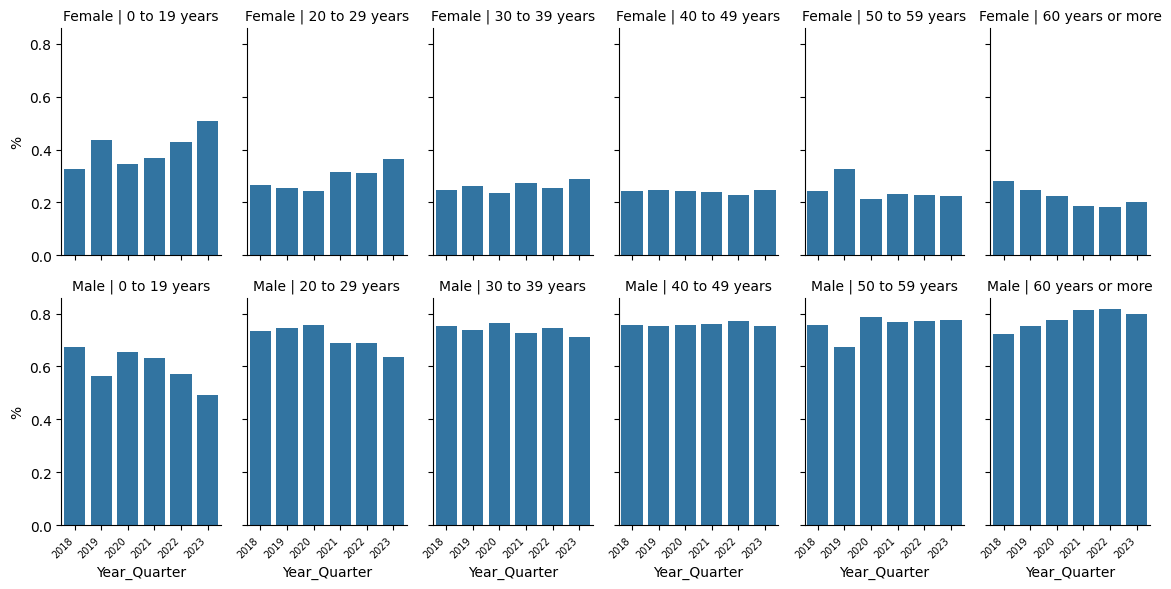

In [176]:
g = sns.FacetGrid(data=gq2_o_2,col='Aggregator',row='Disaggregator',aspect=.65)
g.map_dataframe(sns.barplot, x="Year_Quarter",y='%')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=7)

plt.tight_layout()

##### **Opioid Deaths Sliced by Gender and Age Group**


The charts above illustrate that the **30-39 and 40-49 age groups are predominantly male**, consistently accounting for over 80% of victims. This aligns with earlier findings on age and gender distribution.

However, the proportion of **female victims** in younger age groups have risen significantly in recent years. In the youngest group, the female share increased from 25% to over 50%, while in the next group, it grew from 22% to nearly 40%. Among those aged 60 and older, the percentage of female victims increased in 2023 compared to 2022 but remains lower than in the early years of the dataset, when it was around 25%.

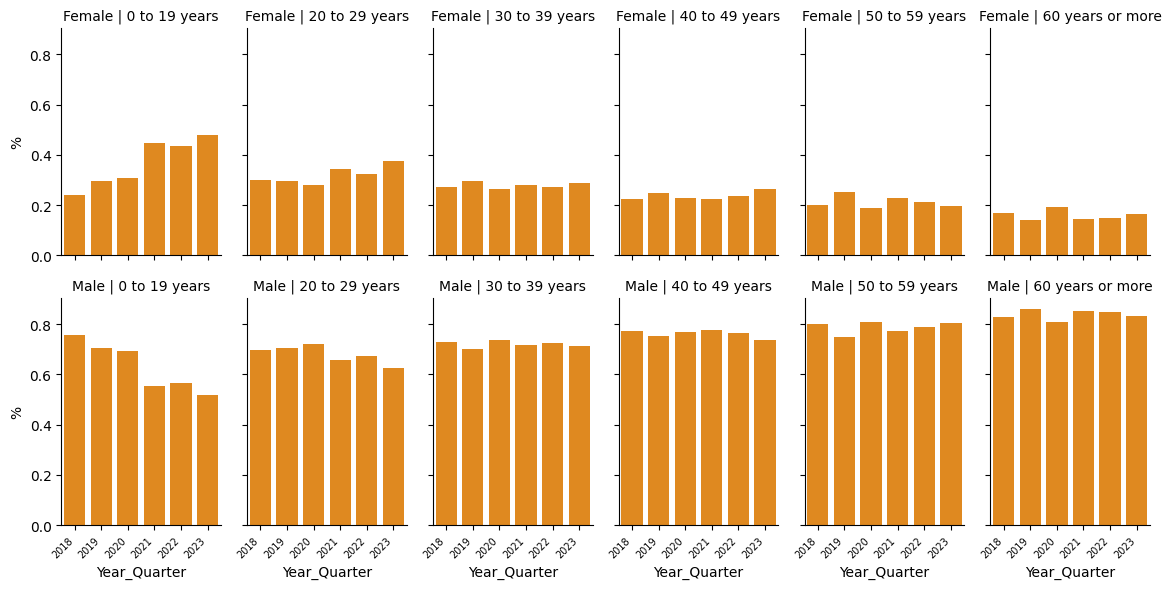

In [177]:
g = sns.FacetGrid(data=gq2_s_2,col='Aggregator',row='Disaggregator',aspect=.65)
g.map_dataframe(sns.barplot, x="Year_Quarter",y='%',color='darkorange')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=7)

plt.tight_layout()

##### **Stimulant Deaths Sliced by Gender and Age Group**

Similar to Opioids, Stimulant-related deaths among females have increased in younger age groups. The percentage of female victims in the 0-19 age group doubled, rising from 24% to 48.1%, while the 20-29 group saw an increase from 30% to 37%. In contrast, other age groups remain largely male-dominated with consistent averages over time.

### Guiding Question 3: Is the weather relevant for the number of incidents?

Q1 (January - March): Winter (cold, snow, shorter daylight hours)

Q2 (April - June): Spring (mild, transitioning to warmer weather)

Q3 (July - September): Summer (warmest, longer daylight hours)

Q4 (October - December): Fall (cooling temperatures, shorter daylight hours)



In [178]:
quarter_data = df[df['Time_Period'] == 'By quarter']
grouped_data = quarter_data.groupby(['Year_Quarter', 'Type_Event'])['Value'].sum().reset_index()

In [179]:
deaths = grouped_data[grouped_data['Type_Event'].str.contains('deaths', case=False)]
hospitalizations = grouped_data[grouped_data['Type_Event'].str.contains('hospitalizations', case=False)]

deaths = deaths.rename(columns={'Value': 'Total_Deaths'})
hospitalizations = hospitalizations.rename(columns={'Value': 'Total_Hospitalizaitions'})

In [180]:
quarter_summary = pd.merge(deaths, hospitalizations, on='Year_Quarter', how='outer')
quarter_summary['Quarter'] = quarter_summary['Year_Quarter'].str.extract(r'Q(\d)')
quarter_summary['Year'] = quarter_summary['Year_Quarter'].str.extract(r'(\d{4})')

In [181]:
average_per_quarter = quarter_summary.groupby(['Quarter'])[['Total_Deaths', 'Total_Hospitalizaitions']].mean().reset_index()
display(average_per_quarter)


,Quarter,Total_Deaths,Total_Hospitalizaitions
0,1,2239.625000,1459.906250
1,2,2313.687500,1627.625000
2,3,2311.857143,1653.571429
3,4,2470.428571,1561.607143


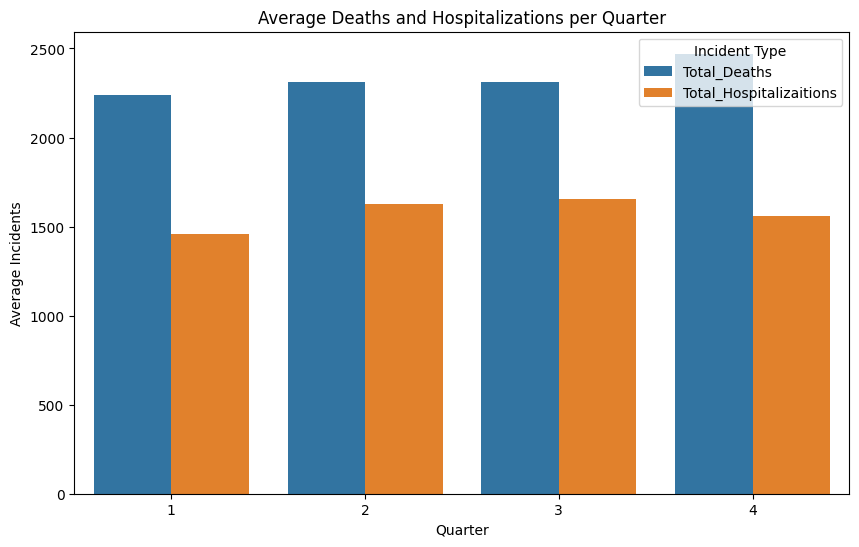

In [227]:
plt.figure(figsize=(10,6))
sns.barplot(x='Quarter', y='value', hue='variable', data=pd.melt(average_per_quarter, id_vars=['Quarter'], value_vars=['Total_Deaths', 'Total_Hospitalizaitions']))
plt.title('Average Deaths and Hospitalizations per Quarter')
plt.xlabel('Quarter')
plt.ylabel('Average Incidents')
plt.legend(title='Incident Type')
plt.show()



**Death rate:  Q4 > Q2 > Q3 > Q1**

Deaths related to opioid and stimulant use are highest in the fourth quarter (October-December) and lowest in the first quarter (January-March).

* The holiday season in Q4 can potentially lead to increased substance use and relapse.

* The colder weather in Q4 could contribute to increased isolation and reduced access to support systems, leading to delayed impact on mortality rates.

* The shorter daylight hours and colder temperatures  in Q4 can trigger or worsen seasonal affective disorder, which may increase the risk of substance abuse and overdose



**Hospitalization rate: Q3 > Q2 > Q4 > Q1**

Hospitalizations related to opioid and stimulant use are highest in the third quarter (July-September) and lowest in the first quarter (January - March).

* Q3 involve more social gatherings and outdoor activities, which could lead to increased substance use and higher risk of overdose requiring hospitalization.

* Hot weather in Q3 can increase the effects of substance use, leading to dehydration, heatstroke, and other complications requiring hospitalization.

* With festivals and events in the summer, substance use may be more prevalent.




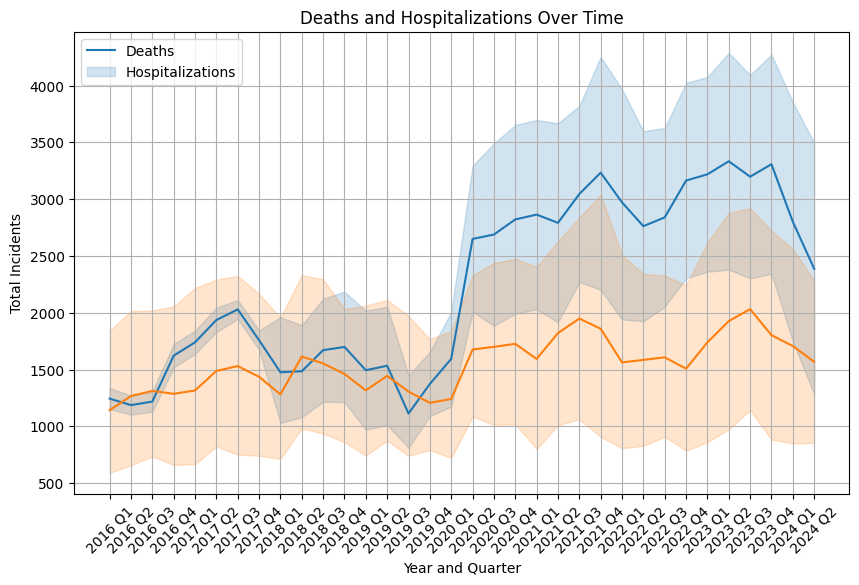

In [183]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Year_Quarter', y='Total_Deaths', data=deaths)
sns.lineplot(x='Year_Quarter', y='Total_Hospitalizaitions', data=hospitalizations)
plt.title('Deaths and Hospitalizations Over Time')
plt.xlabel('Year and Quarter')
plt.ylabel('Total Incidents')
plt.xticks(rotation=45)
plt.legend(labels=['Deaths', 'Hospitalizations'])
plt.grid(True)
plt.show()

There is a notable growth observed around the years 2020 and 2022, a period that coincides with the COVID-19 pandemic. We believe that the pandemic escalated the opioid and stimulant crisis in several ways. First, social isolation left many individuals feeling disconnected and alone, increasing mental health struggles and reliance on substances as a coping mechanism. Second, limited access to healthcare and support services made it harder for people to seek help, leaving many without the care they needed. Third, lockdowns and restrictions disrupted daily routines, cut off access to harm reduction programs, and created barriers to treatment. Additionally, the economic uncertainty and stress pushed more people toward substance use.


While hospitalizations linked to opioid and stimulant use were initially more common than deaths, the two trends have gradually converged and eventually crossed paths. In recent years, deaths have become more frequent than hospitalizations, signaling a troubling shift in the crisis. This change suggests that the situation is growing more severe, with the risk of fatal outcomes now outweighing the chances for timely intervention and treatment. It highlights an urgent need for stronger measures to address the escalating dangers of substance use.

In [184]:
grouped_region = quarter_data.groupby(['Region', 'Year_Quarter', 'Type_Event'])['Value'].sum().reset_index()
grouped_region = grouped_region[grouped_region['Region'] != 'Canada']

In [185]:
deaths_region = grouped_region[grouped_region['Type_Event'].str.contains('deaths', case=False)]
hospitalizations_region = grouped_region[grouped_region['Type_Event'].str.contains('hospitalizations', case=False)]

deaths_region = deaths_region.rename(columns={'Value': 'Total_Deaths'})
hospitalizations_region = hospitalizations_region.rename(columns={'Value': 'Total_Hospitalizations'})

In [186]:
quarter_summary = pd.merge(deaths_region, hospitalizations_region, on=['Region', 'Year_Quarter'], how='outer')

In [187]:
quarter_summary['Quarter'] = quarter_summary['Year_Quarter'].str.extract(r'Q(\d)')
quarter_summary['Year'] = quarter_summary['Year_Quarter'].str.extract(r'(\d{4})')

In [188]:
average_per_quarter_region = quarter_summary.groupby(['Region', 'Quarter'])[['Total_Deaths', 'Total_Hospitalizations']].mean().reset_index()
display(average_per_quarter_region)


,Region,Quarter,Total_Deaths,Total_Hospitalizations
0,Alberta,1,151.531250,127.515625
1,Alberta,2,155.500000,143.750000
2,Alberta,3,160.571429,151.303571
3,Alberta,4,169.142857,136.875000
4,Atlantic Canada,1,25.475806,28.838710
5,Atlantic Canada,2,25.468750,32.328125
6,Atlantic Canada,3,27.857143,32.696429
7,Atlantic Canada,4,29.740741,30.944444
8,British Columbia,1,359.500000,225.265625
9,British Columbia,2,355.843750,240.828125


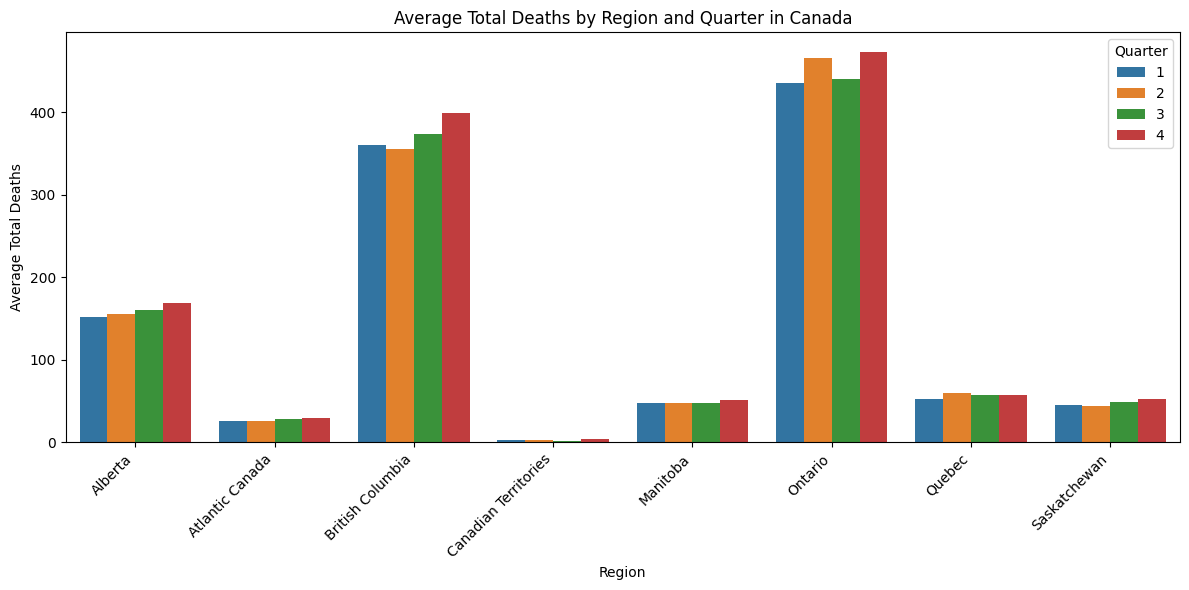

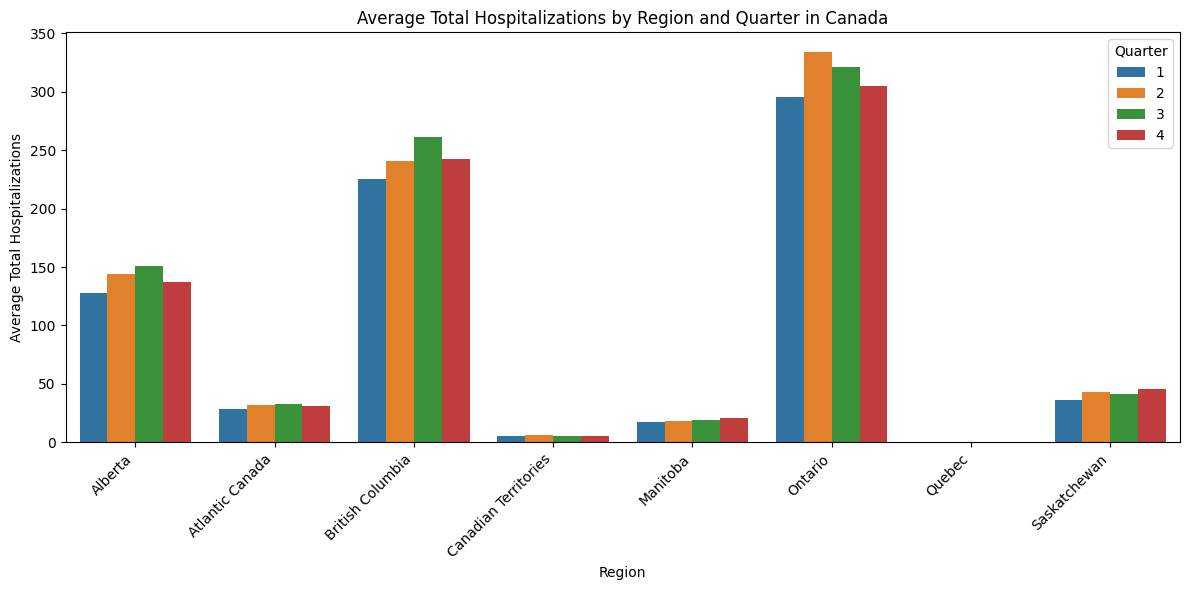

In [189]:
deaths_data = average_per_quarter_region[['Region', 'Quarter', 'Total_Deaths']]
plt.figure(figsize=(12, 6))
sns.barplot(x='Region', y='Total_Deaths', hue='Quarter', data=deaths_data)
plt.title('Average Total Deaths by Region and Quarter in Canada')
plt.xlabel('Region')
plt.ylabel('Average Total Deaths')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

hospitalizations_data = average_per_quarter_region[['Region', 'Quarter', 'Total_Hospitalizations']]

plt.figure(figsize=(12, 6))
sns.barplot(x='Region', y='Total_Hospitalizations', hue='Quarter', data=hospitalizations_data)
plt.title('Average Total Hospitalizations by Region and Quarter in Canada')
plt.xlabel('Region')
plt.ylabel('Average Total Hospitalizations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Both plots exhibit some seasonal variations in deaths and hospitalizations, with deaths tending to peak in the fourth quarter (October-December) and hospitalizations often highest in the third quarter (July-September). These patterns may be attributed to factors such as weather, social gatherings, and holiday seasons, which can influence substance use behaviors.

British Columbia and Ontario show the highest average death and hospitalization rates, indicating more severe crisis of opioids and stimulants compared to other regions.



### Guiding Question 4: What is the share of intentional deaths/hospitalizations overall? Is it increasing or decreasing?

In [190]:
gq4_o_deaths = df.loc[(df['Type_Event'] == 'Total apparent opioid toxicity deaths') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Opioids') & (df['Year_Quarter'] != '2024 (Jan to Jun)') & (df['Specific_Measure'] == 'Overall numbers')]
gq4_o_hosp = df.loc[(df['Type_Event'] == 'Total opioid-related poisoning hospitalizations') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Opioids') & (df['Year_Quarter'] != '2024 (Jan to Jun)') & (df['Specific_Measure'] == 'Overall numbers')]

gq4_s_deaths = df.loc[(df['Type_Event'] == 'Total apparent stimulant toxicity deaths') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Stimulants') & (df['Year_Quarter'] != '2024 (Jan to Jun)') & (df['Specific_Measure'] == 'Overall numbers')]
gq4_s_hosp = df.loc[(df['Type_Event'] == 'Total stimulant-related poisoning hospitalizations') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Substance'] == 'Stimulants') & (df['Year_Quarter'] != '2024 (Jan to Jun)') & (df['Specific_Measure'] == 'Overall numbers')]

In [191]:
gq4_o_deaths = gq4_o_deaths[['Year_Quarter','Region','Value']]
gq4_o_deaths.columns = ['Year','Region','Deaths']
gq4_o_hosp = gq4_o_hosp[['Year_Quarter','Region','Value']]
gq4_o_hosp.columns = ['Year','Region','Hospitalizations']
gq4_o_final = gq4_o_deaths.merge(gq4_o_hosp,on=['Year','Region'],how='inner')

gq4_s_deaths = gq4_s_deaths[['Year_Quarter','Region','Value']]
gq4_s_deaths.columns = ['Year','Region','Deaths']
gq4_s_hosp = gq4_s_hosp[['Year_Quarter','Region','Value']]
gq4_s_hosp.columns = ['Year','Region','Hospitalizations']
gq4_s_final = gq4_s_deaths.merge(gq4_s_hosp,on=['Year','Region'],how='inner')

In [192]:
gq4_o_final['%'] = gq4_o_final['Deaths']/gq4_o_final['Hospitalizations']
gq4_s_final['%'] = gq4_s_final['Deaths']/gq4_s_final['Hospitalizations']

In [193]:
gq4_o_final = gq4_o_final.groupby(['Year', 'Region'], as_index=False)['%'].mean()
gq4_o_final = pd.pivot(data=gq4_o_final, index='Region', columns='Year', values='%').reset_index()
gq4_o_final = gq4_o_final.set_index('Region')

gq4_s_final = gq4_s_final.groupby(['Year', 'Region'], as_index=False)['%'].mean()
gq4_s_final = pd.pivot(data=gq4_s_final, index='Region', columns='Year', values='%').reset_index()
gq4_s_final = gq4_s_final.set_index('Region')

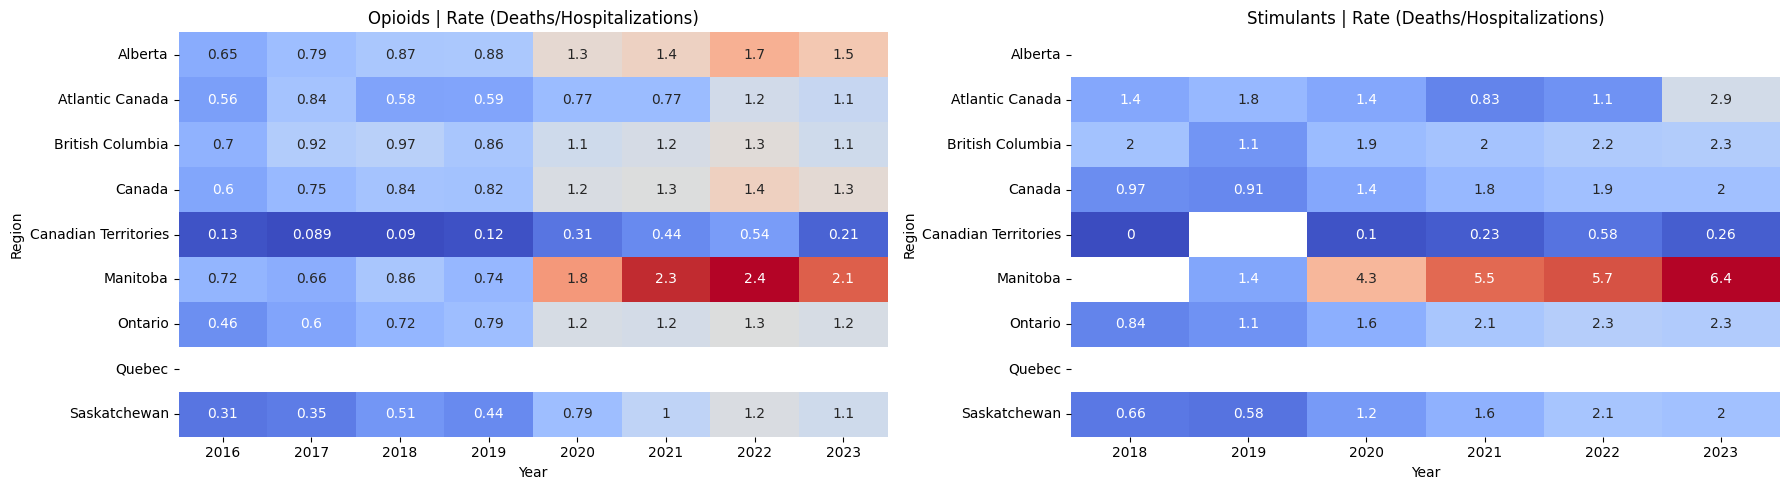

In [194]:
fig3, axes3 = plt.subplots(1, 2, figsize=(18, 5))

sns.heatmap(data=gq4_o_final,cmap='coolwarm',ax=axes3[0],annot=True,cbar=False)
axes3[0].set_title('Opioids | Rate (Deaths/Hospitalizations)')
axes3[0].set_ylabel('Region')
axes3[0].set_xlabel('Year')

sns.heatmap(data=gq4_s_final,cmap='coolwarm',ax=axes3[1],annot=True,cbar=False)
axes3[1].set_title('Stimulants | Rate (Deaths/Hospitalizations)')
axes3[1].set_ylabel('Region')
axes3[1].set_xlabel('Year')

plt.tight_layout()


The **death-to-hospitalization rate** is a critical metric for understanding the trajectory of this crisis. While we observe growth in this rate (as shown on Guiding Question #1), **a rate lower than 1 suggests that hospitalizations are outpacing deaths**, offering a chance to save more lives. However, the data from the past three years across all regions, including Canada, indicates that the rate has consistently exceeded 1 in all provinces except Territories. **For instance, in 2023, Manitoba had twice as many deaths as hospitalizations, while Alberta had a rate of 1.5.**

A concerning trend is the increase in this rate across all regions from 2016 to 2023, especially during the pandemic years (2020-2022). This points to a worsening situation that will likely be more difficult to control than before. Education on harm reduction and guidance on treatment options in hospitals and other healthcare facilities are key to reducing this rate, saving lives, and improving the overall situation.

The trend for **stimulants follow a similar pattern, but with even more alarming figures**. All regions that reported data (except for the Territories) have a death-to-hospitalization rate higher than 2, indicating that fatalities are twice as frequent as hospitalizations, with little chance for intervention. **Manitoba, in particular, stands out as the most affected province on both fronts.**

### Guiding Question 5: What is the difference if we deep-dive by Age Groups and Gender?

In [195]:
gq4_o_deaths_2 = df.loc[(df['Type_Event'] == 'Accidental apparent opioid toxicity deaths') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Year_Quarter'] != '2024 (Jan to Jun)')]
gq4_o_hosp_2 = df.loc[(df['Type_Event'] == 'Accidental opioid-related poisoning hospitalizations') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Year_Quarter'] != '2024 (Jan to Jun)')]

gq4_s_deaths_2 = df.loc[(df['Type_Event'] == 'Accidental apparent stimulant toxicity deaths') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Year_Quarter'] != '2024 (Jan to Jun)')]
gq4_s_hosp_2 = df.loc[(df['Type_Event'] == 'Accidental stimulant-related poisoning hospitalizations') & (df['Unit'] == 'Number') & (df['Time_Period'] == 'By year') & (df['Year_Quarter'] != '2024 (Jan to Jun)')]

In [196]:
gq4_o_deaths_2 = gq4_o_deaths_2.loc[gq4_o_deaths_2['Aggregator'].isin(age_groups)]
gq4_o_hosp_2 = gq4_o_hosp_2.loc[gq4_o_hosp_2['Aggregator'].isin(age_groups)]

gq4_o_deaths_2 = gq4_o_deaths_2[['Year_Quarter', 'Aggregator', 'Disaggregator','Value']]
gq4_o_deaths_2.columns = ['Year','Age_Group','Gender','Deaths']

gq4_o_hosp_2 = gq4_o_hosp_2[['Year_Quarter', 'Aggregator', 'Disaggregator','Value']]
gq4_o_hosp_2.columns = ['Year','Age_Group','Gender','Hospitalizations']

gq4_s_deaths = gq4_s_deaths_2.loc[gq4_s_deaths_2['Aggregator'].isin(age_groups)]
gq4_s_hosp = gq4_s_hosp_2.loc[gq4_s_hosp_2['Aggregator'].isin(age_groups)]
gq4_s_deaths_2 = gq4_s_deaths_2[['Year_Quarter', 'Aggregator', 'Disaggregator','Value']]
gq4_s_deaths_2.columns = ['Year','Age_Group','Gender','Deaths']
gq4_s_hosp_2 = gq4_s_hosp_2[['Year_Quarter', 'Aggregator', 'Disaggregator','Value']]
gq4_s_hosp_2.columns = ['Year','Age_Group','Gender','Hospitalizations']

In [197]:
gq4_o_deaths_2 = gq4_o_deaths_2.groupby(by=['Year','Age_Group','Gender']).sum().reset_index()
gq4_o_hosp_2 = gq4_o_hosp_2.groupby(by=['Year','Age_Group','Gender']).sum().reset_index()

gq4_s_deaths_2 = gq4_s_deaths_2.groupby(by=['Year','Age_Group','Gender']).sum().reset_index()
gq4_s_hosp_2 = gq4_s_hosp_2.groupby(by=['Year','Age_Group','Gender']).sum().reset_index()

In [198]:
gq4_o_final_2 = gq4_o_deaths_2.merge(gq4_o_hosp_2,on=['Year','Age_Group','Gender'],how='inner')
gq4_s_final_2 = gq4_s_deaths_2.merge(gq4_s_hosp_2,on=['Year','Age_Group','Gender',],how='inner')

In [199]:
gq4_o_final_2['%'] = gq4_o_final_2['Deaths']/gq4_o_final_2['Hospitalizations']
gq4_s_final_2['%'] = gq4_s_final_2['Deaths']/gq4_s_final_2['Hospitalizations']

In [200]:
gq4_o_final_2_m = gq4_o_final_2.loc[gq4_o_final_2['Gender'] == 'Male']
gq4_o_final_2_f = gq4_o_final_2.loc[gq4_o_final_2['Gender'] == 'Female']

gq4_s_final_2_m = gq4_s_final_2.loc[gq4_s_final_2['Gender'] == 'Male']
gq4_s_final_2_f = gq4_s_final_2.loc[gq4_s_final_2['Gender'] == 'Female']

In [201]:
gq4_o_final_2_m = gq4_o_final_2_m.groupby(['Year', 'Age_Group'], as_index=False)['%'].mean()
gq4_o_final_2_f = gq4_o_final_2_f.groupby(['Year', 'Age_Group'], as_index=False)['%'].mean()

gq4_s_final_2_m = gq4_s_final_2_m.groupby(['Year', 'Age_Group'], as_index=False)['%'].mean()
gq4_s_final_2_f = gq4_s_final_2_f.groupby(['Year', 'Age_Group'], as_index=False)['%'].mean()

In [202]:
gq4_o_final_2_m = pd.pivot(data=gq4_o_final_2_m, index='Age_Group', columns='Year', values='%').reset_index()
gq4_o_final_2_m = gq4_o_final_2_m.set_index('Age_Group')

gq4_o_final_2_f = pd.pivot(data=gq4_o_final_2_f, index='Age_Group', columns='Year', values='%').reset_index()
gq4_o_final_2_f = gq4_o_final_2_f.set_index('Age_Group')

gq4_s_final_2_m = pd.pivot(data=gq4_s_final_2_m, index='Age_Group', columns='Year', values='%').reset_index()
gq4_s_final_2_m = gq4_s_final_2_m.set_index('Age_Group')

gq4_s_final_2_f = pd.pivot(data=gq4_s_final_2_f, index='Age_Group', columns='Year', values='%').reset_index()
gq4_s_final_2_f = gq4_s_final_2_f.set_index('Age_Group')

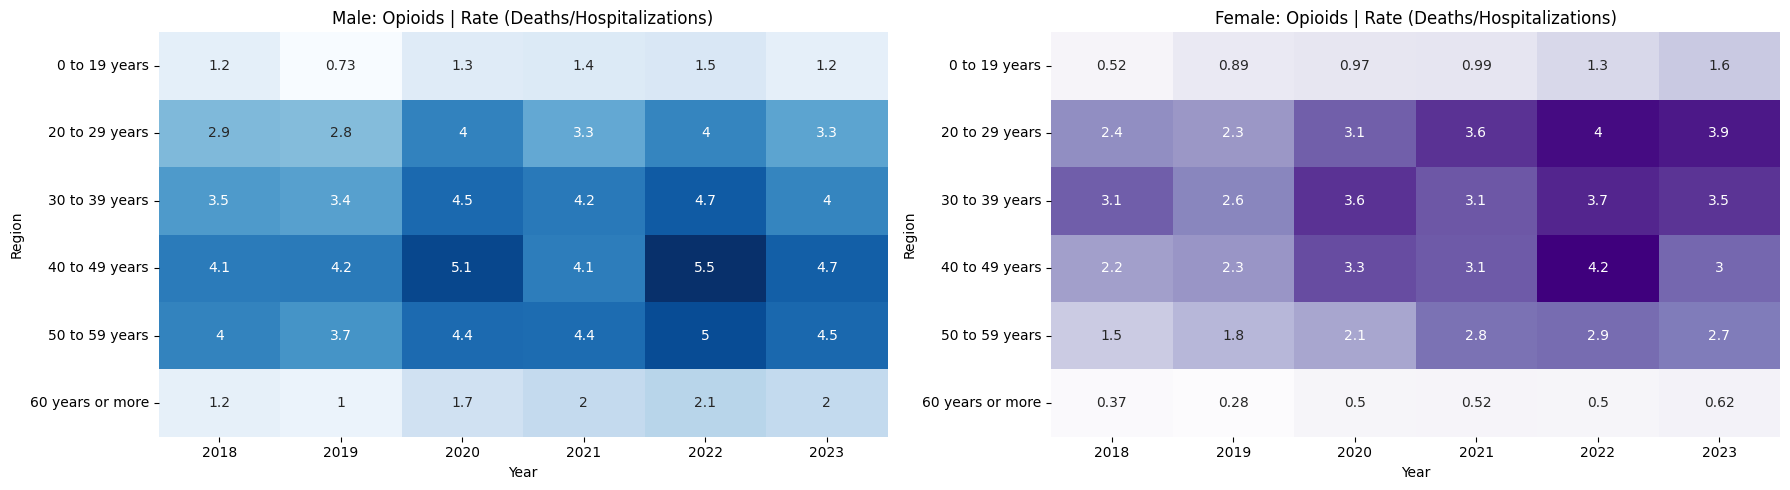

In [203]:
fig4, axes4 = plt.subplots(1, 2, figsize=(18, 5))

sns.heatmap(data=gq4_o_final_2_m,cmap='Blues',ax=axes4[0],annot=True,cbar=False)

axes4[0].set_title('Male: Opioids | Rate (Deaths/Hospitalizations)')
axes4[0].set_ylabel('Region')
axes4[0].set_xlabel('Year')

sns.heatmap(data=gq4_o_final_2_f,cmap='Purples',ax=axes4[1],annot=True,cbar=False)
axes4[1].set_title('Female: Opioids | Rate (Deaths/Hospitalizations)')
axes4[1].set_ylabel('Region')
axes4[1].set_xlabel('Year')

plt.tight_layout()

##### Opioids

The death-to-hospitalization rate for **males** remains above 1 across all age groups, highlighting a severe issue—many cases are beyond recovery. While higher rates in middle-aged groups are expected, the **alarming fact is that both young individuals (under 19) and older adults (over 60)** also exhibit these high rates. This raises critical concerns about what preventive measures can be taken to address the issue in these vulnerable groups.

For **females**, the trend is somewhat similar; however, the oldest age group shows a rate below 1, indicating a slightly less severe situation. Additionally, the **peak values for females are significantly lower than those for males**, which aligns with the 70/30 case distribution observed earlier.

One **positive takeaway** is the notable decline from 2022 to 2023, suggesting that public policies and interventions are having an impact. This improvement signals that the crisis is receiving increased attention and that efforts to address it may be showing results.

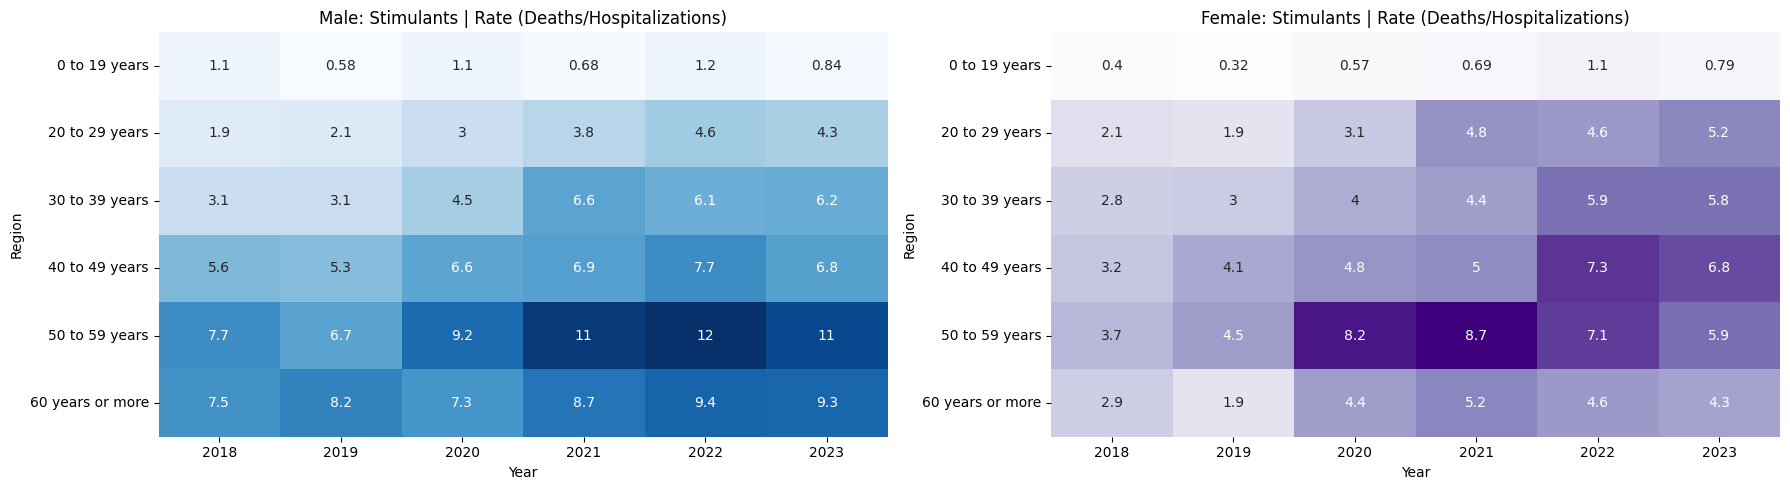

In [204]:
fig4, axes4 = plt.subplots(1, 2, figsize=(18, 5))

sns.heatmap(data=gq4_s_final_2_m,cmap='Blues',ax=axes4[0],annot=True,cbar=False)

axes4[0].set_title('Male: Stimulants | Rate (Deaths/Hospitalizations)')
axes4[0].set_ylabel('Region')
axes4[0].set_xlabel('Year')

sns.heatmap(data=gq4_s_final_2_f,cmap='Purples',ax=axes4[1],annot=True,cbar=False)
axes4[1].set_title('Female: Stimulants | Rate (Deaths/Hospitalizations)')
axes4[1].set_ylabel('Region')
axes4[1].set_xlabel('Year')

plt.tight_layout()

##### Stimulants

**The death-to-hospitalization rate for stimulants presents an even more alarming scenario**. Among **males**, the 50–59 age group has maintained a **rate above 10** for the past three years, meaning that for every one hospitalization, there are ten fatalities. Even more concerning is that the 60+ age group also approaches this critical threshold. Authorities must investigate the underlying causes behind such extreme substance abuse in these demographics. For instance, if a particular occupation or social factor is contributing to this crisis, targeted awareness campaigns could help mitigate the issue. **Unlike the trend observed with opioids, there is no significant decline in stimulant-related fatalities** from 2022 to 2023, indicating that the crisis remains severe and unresolved.

A similar pattern is evident among **females, where stimulant-related death rates surpass those of opioids**, particularly in the oldest two age groups. Unlike opioids, which emerged as a public health crisis nearly a decade ago, stimulants have been widely known and present in society for many years. The fact that these rates remain exceptionally high for both men and women underscore the urgent need for intervention and comprehensive public health strategies.

### Guiding Question 6: Can we draw a correlation between homicides/crime rate and substance abuse?



##### Absolute numbers of Crimes and Substance Abuse

The assumption here is that the provinces with a higher activity of organized crime and/or higher rate of homicides (normalized by the population) will also have the worst metrics for Deaths and Death-to-Hospitalization rates, since the presence of criminals might be a factor indicating more abundance of these substances.

In [205]:
eq_df_o = eq_df.loc[eq_df['Substance'] == 'Opioids']
eq_df_s = eq_df.loc[eq_df['Substance'] == 'Stimulants']

In [206]:
eq_df_o = eq_df_o.loc[eq_df_o['Unit'] == 'Number'].groupby(by=['Substance','Type_Event','Region','Year_Quarter']).sum().reset_index()
eq_df_s = eq_df_s.loc[eq_df_s['Unit'] == 'Number'].groupby(by=['Substance','Type_Event','Region','Year_Quarter']).sum().reset_index()

In [207]:
merged_df_o = eq_df_o.merge(crime_1,left_on=['Region','Year_Quarter'],right_on=['GEO','REF_DATE'],how='inner')
merged_df_s = eq_df_s.merge(crime_1,left_on=['Region','Year_Quarter'],right_on=['GEO','REF_DATE'],how='inner')

In [208]:
#Cleaning the Dataset to make it easier to perform the analysis
merged_df_o = merged_df_o[['Region','Year_Quarter','Total Deaths','Homicides']]
merged_df_s = merged_df_s[['Region','Year_Quarter','Total Deaths','Homicides']]

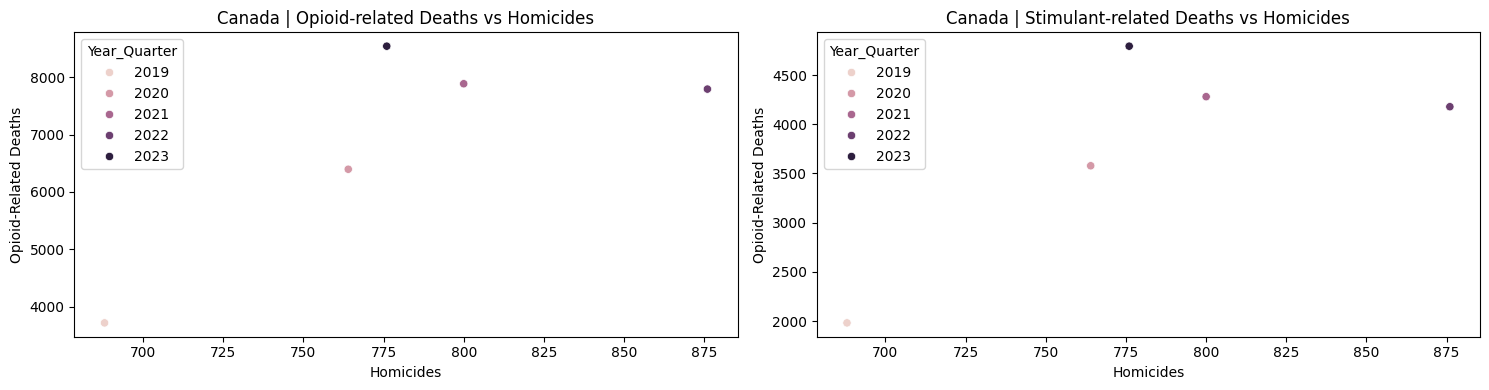

In [209]:
fig5, axes5 = plt.subplots(1, 2, figsize=(15, 4))

sns.scatterplot(data=merged_df_o.loc[merged_df_o['Region'] == 'Canada'],y='Total Deaths',x='Homicides',ax=axes5[0],hue='Year_Quarter')
axes5[0].set_title('Canada | Opioid-related Deaths vs Homicides')
axes5[0].set_ylabel('Opioid-Related Deaths')
axes5[0].set_xlabel('Homicides')

sns.scatterplot(data=merged_df_s.loc[merged_df_s['Region'] == 'Canada'],y='Total Deaths',x='Homicides',ax=axes5[1],hue='Year_Quarter')
axes5[1].set_title('Canada | Stimulant-related Deaths vs Homicides')
axes5[1].set_ylabel('Opioid-Related Deaths')
axes5[1].set_xlabel('Homicides')

plt.tight_layout()

Examining the data across Canada, we see that in 2019, the combined numbers were significantly lower compared to 2022 and 2023. **This suggests a positive correlation**, as the numbers have increased together over time. A more insightful approach would be to analyze this trend **at the provincial level for a clearer understanding**.

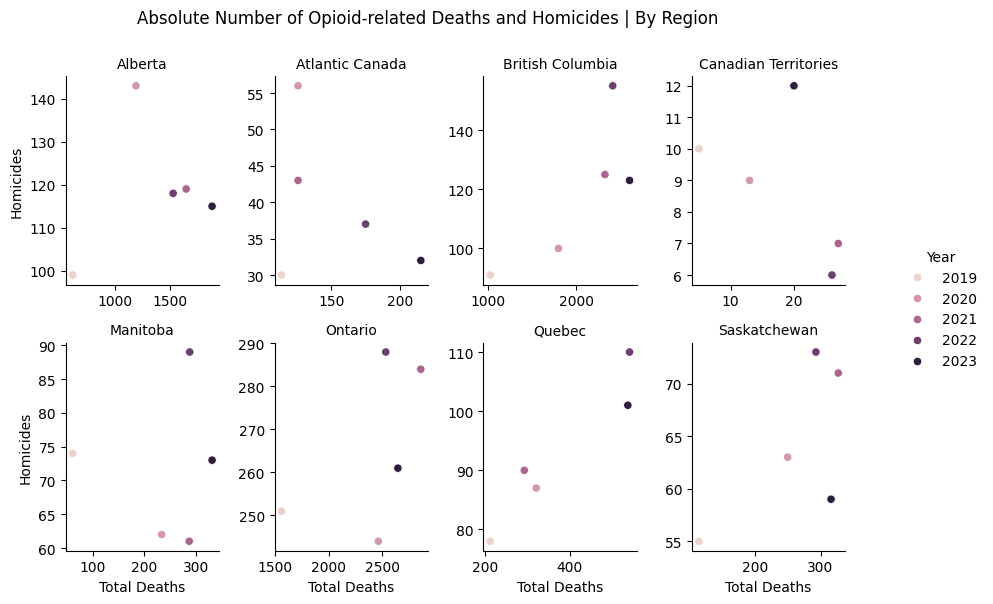

In [210]:
g3 = sns.FacetGrid(data=merged_df_o.loc[merged_df_o['Region'] != 'Canada'],col_wrap=4,col='Region',aspect=.65,sharex=False, sharey=False)
g3.map_dataframe(sns.scatterplot, x="Total Deaths",y='Homicides',color='darkorange',hue='Year_Quarter')
g3.set_titles(col_template="{col_name}", row_template="{row_name}")
g3.add_legend(title="Year", bbox_to_anchor=(1.15, 0.5), loc="center right")
g3.fig.suptitle("Absolute Number of Opioid-related Deaths and Homicides | By Region", fontsize=12, y=1)
plt.tight_layout()

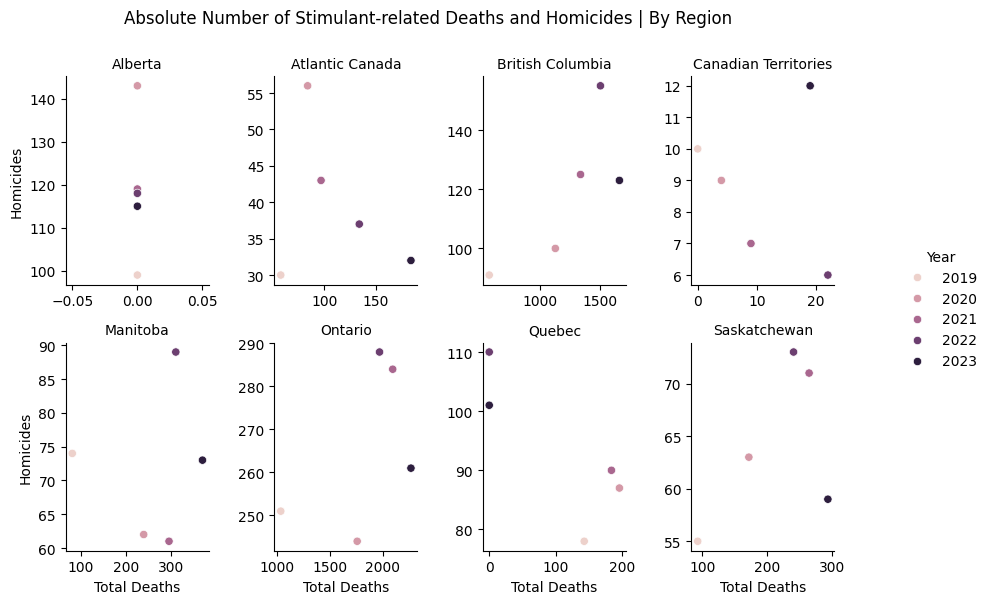

In [211]:
g3 = sns.FacetGrid(data=merged_df_s.loc[merged_df_s['Region'] != 'Canada'],col_wrap=4,col='Region',aspect=.65,sharex=False, sharey=False)
g3.map_dataframe(sns.scatterplot, x="Total Deaths",y='Homicides',color='darkorange',hue='Year_Quarter')
g3.set_titles(col_template="{col_name}", row_template="{row_name}")
g3.add_legend(title="Year", bbox_to_anchor=(1.15, 0.5), loc="center right")
g3.fig.suptitle("Absolute Number of Stimulant-related Deaths and Homicides | By Region", fontsize=12, y=1)
plt.tight_layout()


Since both substances (Opioids and Stimulants) are illegal, we can observe a correlation between **gang-related homicides** (a proxy for gang activity in a province) and **substance-related deaths**. As seen in the death statistics (Guiding Questions 1 and 4), this trend has surged dramatically over the past two years. In most provinces, crime rates have been rising at a similar pace. Looking at the charts for **British Columbia, Ontario, and Manitoba** for Opioids and BC and ON for Stimulants, we see clear spikes in both deaths and gang-related homicides in 2022 and 2023, **highlighting this alarming trend seen in previous questions**.

##### Relative numbers (Rate per 100,000) of Crimes and Substance Abuse

In [212]:
#Filtering only Organized Crime Homicides
crime_2 = crime_dataset.loc[crime_dataset['Homicides'] == 'Rate of homicides (number of victims per 100,000 population) where the homicide was linked or suspected to be linked to organized crime or a street gang']

#Renaming to avoid confusion before merging
crime_2 = crime_2.rename({'Homicides':'Category','VALUE':'Homicide Rate'},axis=1)
crime_2 = crime_2[['REF_DATE','GEO','Homicide Rate']]

In [213]:
#Filtering only Total Deaths related to Substances to Start the analysis
eq_df_2 = df.loc[(df['Source'] == 'Deaths') & (df['Time_Period'] == 'By year') & (df['Specific_Measure'] == 'Overall numbers') & (df['Year_Quarter'] != '2024 (Jan to Jun)')]
eq_df_2 = eq_df_2.loc[(eq_df_2['Type_Event'] == 'Total apparent opioid toxicity deaths') | (eq_df_2['Type_Event'] == 'Total apparent stimulant toxicity deaths')]

#Cleaning the Dataset to make it easier for manipulation
eq_df_2 = eq_df_2[['Substance','Type_Event','Region','Year_Quarter','Unit','Value']]
eq_df_2 = eq_df_2.rename({'Value':'Death Rate'},axis=1)
#Converting Year to int
eq_df_2['Year_Quarter']=eq_df_2['Year_Quarter'].astype(int)

In [214]:
eq_df2_o = eq_df_2.loc[eq_df['Substance'] == 'Opioids']
eq_df2_s = eq_df_2.loc[eq_df['Substance'] == 'Stimulants']

eq_df2_o = eq_df2_o.loc[eq_df2_o['Unit'] == 'Crude rate'].groupby(by=['Substance','Type_Event','Region','Year_Quarter'])[['Death Rate']].mean().reset_index()
eq_df2_s = eq_df2_s.loc[eq_df2_s['Unit'] == 'Crude rate'].groupby(by=['Substance','Type_Event','Region','Year_Quarter'])[['Death Rate']].mean().reset_index()

In [215]:
merged_df2_o = eq_df2_o.merge(crime_2,left_on=['Region','Year_Quarter'],right_on=['GEO','REF_DATE'],how='inner')
merged_df2_s = eq_df2_s.merge(crime_2,left_on=['Region','Year_Quarter'],right_on=['GEO','REF_DATE'],how='inner')

In [216]:
#Cleaning the Dataset to make it easier to perform the analysis
merged_df2_o = merged_df2_o[['Region','Year_Quarter','Death Rate','Homicide Rate']]
merged_df2_s = merged_df2_s[['Region','Year_Quarter','Death Rate','Homicide Rate']]

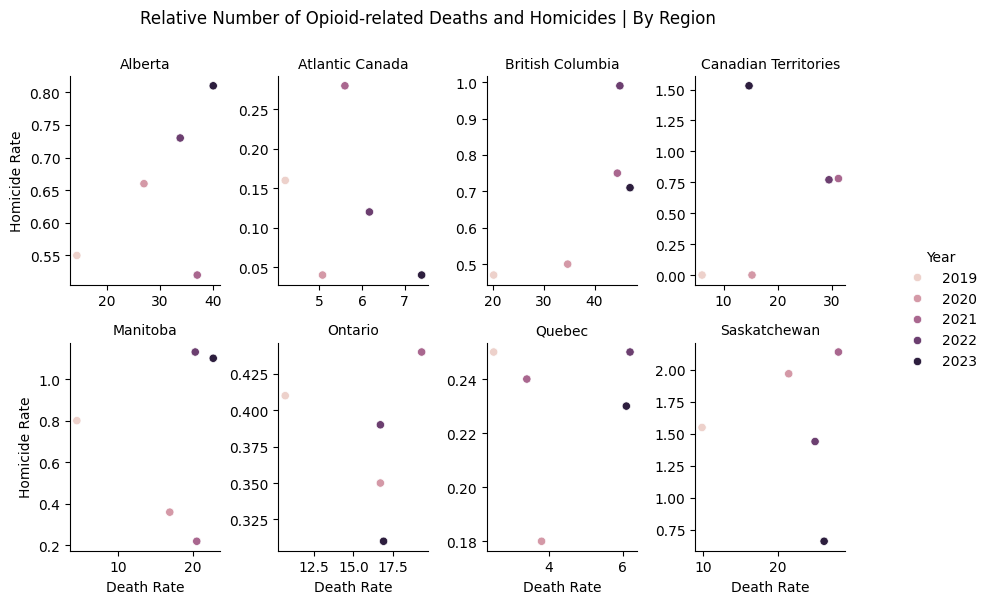

In [217]:
g3 = sns.FacetGrid(data=merged_df2_o.loc[merged_df2_o['Region'] != 'Canada'],col_wrap=4,col='Region',aspect=.65,sharex=False, sharey=False)
g3.map_dataframe(sns.scatterplot, x="Death Rate",y='Homicide Rate',color='darkorange',hue='Year_Quarter')
g3.set_titles(col_template="{col_name}", row_template="{row_name}")
g3.add_legend(title="Year", bbox_to_anchor=(1.15, 0.5), loc="center right")
g3.fig.suptitle("Relative Number of Opioid-related Deaths and Homicides | By Region", fontsize=12, y=1)
plt.tight_layout()

##### Opioids
When normalizing the data by population size, new trends emerge:
* **Alberta** experienced consistent growth in both metrics from 2020 to 2023, with the only exception being in 2022.
* **Manitoba** in contrast, saw a sharp increase in homicide rates in 2022 and 2023, despite having much lower rates in previous years, even though opioid-related deaths remained high.
* On the other hand, the less populated regions of the country, including **Saskatchewan, the Atlantic provinces, and the Territories**, have been witnessing a decline in both homicide and opioid-related death rates in recent years.

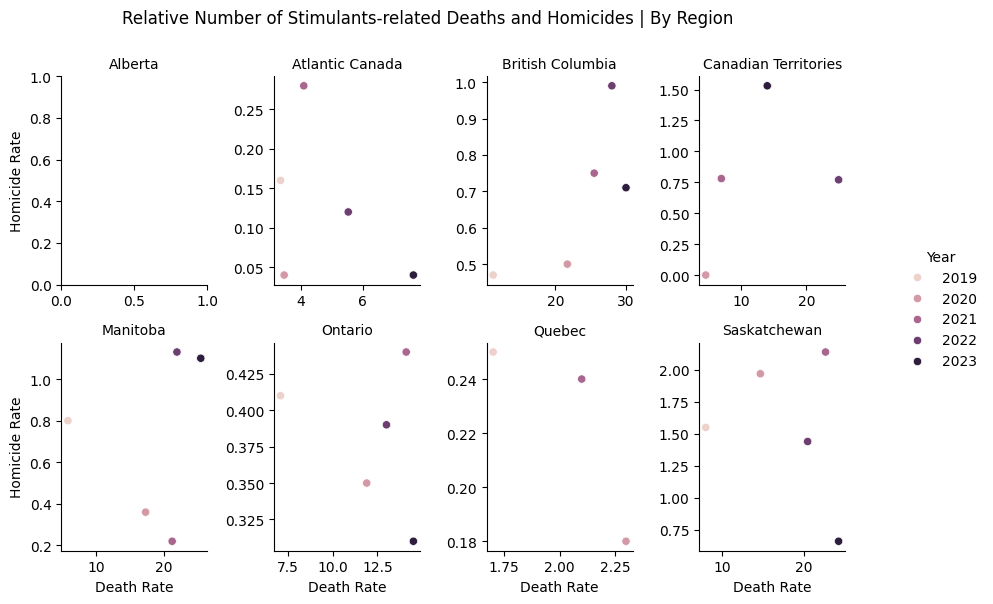

In [218]:
g3 = sns.FacetGrid(data=merged_df2_s.loc[merged_df2_s['Region'] != 'Canada'],col_wrap=4,col='Region',aspect=.65,sharex=False, sharey=False)
g3.map_dataframe(sns.scatterplot, x="Death Rate",y='Homicide Rate',color='darkorange',hue='Year_Quarter')
g3.set_titles(col_template="{col_name}", row_template="{row_name}")
g3.add_legend(title="Year", bbox_to_anchor=(1.15, 0.5), loc="center right")
g3.fig.suptitle("Relative Number of Stimulants-related Deaths and Homicides | By Region", fontsize=12, y=1)
plt.tight_layout()

##### Stimulants

When examining the relative data for stimulants, troubling patterns emerge once again. **Manitoba and British Columbia** have seen an increase in both rates over the years, suggesting higher activity in these provinces. In contrast, **Saskatchewan, Atlantic Canada, and Ontario** (only in 2023) have experienced a decline in these rates. Notably, Alberta has not disclosed data on stimulant-related deaths.

## **Conclusion**

The analysis of opioid and stimulant-related harms in Canada reveals significant regional and demographic trends. The highest growth in opioid-related deaths occurred in **Manitoba and Saskatchewan**, while stimulant-related deaths were more prevalent in **central Canada**. The most affected demographic was **males aged 30-39**, though stimulant-related deaths among **younger females** have shown a concerning increase. Seasonal patterns were evident, with the highest number of deaths occurring in **Q4 (October–December)** and the lowest in **Q1 (January–March)**. Notably, the years **2020–2022** saw a sharp increase in deaths related to both substances, likely exacerbated by the **COVID-19 pandemic**. Geographically, **British Columbia and Ontario** reported the highest average death and hospitalization rates for opioids and stimulants. Additionally, **Manitoba** had a death-to-hospitalization rate twice as high as Alberta, highlighting regional disparities in the severity of the crisis.

The substance abuse crisis is widespread across Canada, with no clear indication that it has peaked or that current measures are effectively reducing the numbers. To address these trends, Canada must prioritize expanding access to harm reduction services, particularly in high-risk regions.


## **References**



* Canadian Centre on Substance Use and Addiction. Opioids. Available at:https://www.ccsa.ca/opioids#:~:text=Canada%20is%20experiencing%20a%20drug,involved%20stimulants%20or%20other%20substances.

* Public Health Agency of Canada. (2023). Opioid- and Stimulant-related Harms in Canada [Dataset]. Health Infobase. https://health-infobase.canada.ca/substance-related-harms/opioids-stimulants/

* Statistics Canada. (2023). Homicides in Canada, by province/territory and link to organized crime or street gangs. https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3510017801

